# Task-Space Control of a 6 dof manipulator

## Imort all the modules needed for the simulation

In [1]:
from pickle import GLOBAL
from mpl_toolkits import mplot3d
import pinocchio as pin
import numpy as np
import sys
import os
from os.path import dirname, join, abspath
from pinocchio.visualize import MeshcatVisualizer
import time
import math
import meshcat
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve
from scipy.spatial.transform import Rotation
import meshcat.transformations as tf
import meshcat.geometry as g
from numpy.linalg import inv,pinv,eig,norm,svd,det
plt.rcParams['text.usetex'] = True
#%matplotlib notebook

## Meshcat functions

In [2]:
def meshcat_material(r, g, b, a):
    import meshcat

    material = meshcat.geometry.MeshPhongMaterial()
    material.color = int(r * 255) * 256 ** 2 + int(g * 255) * 256 + int(b * 255)
    material.opacity = a
    return material


## Bring the URDF model of the robot 

In [3]:
pinocchio_model_dir = '/home/unknown/Documents/Posdoc/ModelsCads/urdf' 
mesh_dir = pinocchio_model_dir + '/kinova_description/meshes/'
urdf_model_path =pinocchio_model_dir + '/j2s6s200_simple.urdf'
model, collision_model, visual_model = pin.buildModelsFromUrdf(urdf_model_path, mesh_dir)
# Choose of the visualizer
viz = MeshcatVisualizer(model, collision_model, visual_model)

## Identify the frame and joint IDs

In [4]:
frameIndex = model.getFrameId('j2s6s200_end_effector')
jointIndex = model.frames[frameIndex].parent

## Initialize the viewer

In [5]:
try:
    viz.initViewer()
except ImportError as err:
    print("Error while initializing the viewer. It seems you should install gepetto-viewer")
    print(err)
    sys.exit(0)

try:
    viz.loadViewerModel("pinocchio")
except AttributeError as err:
    print("Error while loading the viewer model. It seems you should start gepetto-viewer")
    print(err)
    sys.exit(0)
viz.viewer['world'].set_transform(np.array(pin.XYZQUATToSE3([0, 0, 0, 0, 0, 1, 0])))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [20]:
def mprint(M, name="ans",eps=1e-15):
    '''
    Matlab-style pretty matrix print.
    '''
    if isinstance(M, pin.SE3):
        M = M.homogeneous
    if len(M.shape) == 1:
        M = np.expand_dims(M, axis=0)
    ncol = M.shape[1]
    NC = 6
    print(name, " = ")
    print()

    Mmin = lambda M: M.min()
    Mmax = lambda M: M.max()
    Mm = Mmin(abs(M[np.nonzero(M)]))
    MM = Mmax(abs(M[np.nonzero(M)]))

    fmt = "% 10.4f" if Mm < 1e-5 or MM > 1e6 or MM / Mm > 1e3 else "% 1.5f"
    for i in range(math.floor((ncol - 1) / NC + 1)):
        cmin = i * 6
        cmax = (i + 1) * 6
        cmax = ncol if ncol < cmax else cmax
        print("Columns %s through %s" % (cmin, cmax - 1))
        print()
        for r in range(M.shape[0]):
            sys.stdout.write("  ")
            for c in range(cmin, cmax):
                if abs(M[r,c])>eps: sys.stdout.write(fmt % M[r,c]  + "   ")
                else: sys.stdout.write(" 0"+" "*9)
            print()
        print()

## Manipulator dynamic model

\begin{equation}
\mathbf{
M(q)\ddot{q} + C(q,\dot{q})\dot{q} + g(q) = \tau }
\label{eq:01}
\end{equation}

### The closed loop control law $\tau$ can be written 

\begin{equation}
\mathbf{
{\tau} = M(q)u +  g(q) + C(q,\dot{q})}
\end{equation}
where
\begin{equation}
\mathbf{
u = J^{-1}(q)(\ddot{x}_d+ K_d \dot{\tilde{x}} + K_p {\tilde{x}} - \dot{J}\dot{q})};  ~~~~~~ \tilde{x}= x_d - x
\end{equation} 

## Simulation function

In [24]:
def run_robot():
    # This code is only to show the manipulability ellipsoids. Changing the initial conditions
    # will give you different manipulability ellipsoids. The goal of this code is mainly for didactic purposes
    
    # Create data required by the algorithms
    data = model.createData()

    # Sample a random configuration
    q =np.array([np.pi, np.pi/2, np.pi, np.pi, np.pi,np.pi])
    qdot = pin.utils.zero(model.nv) # this is the angular velocity 
    a = pin.utils.zero(model.nv)

    pin.forwardKinematics(model,data,q)
    pin.updateFramePlacements(model,data) #Computes the placement of all the joints
    OM_act=data.oMf[model.getFrameId("j2s6s200_end_effector")]
 
    # Control variables
    nuvs = 7
    kvs = np.array([nuvs, nuvs, nuvs, nuvs, nuvs, nuvs])
    Kv = np.diag(kvs)

    luvs = 5
    kps = np.array([luvs, luvs, luvs,luvs, luvs, luvs])
    Kp = np.diag(kps)
    
    ## For impedance ellipse
    d1 =20; d2 =20;  d3 =20; 
    ds = np.array([d1, d2, d3])
    Dd = np.diag(ds) #  Damper Matrix

    md1 =10; md2 =10;  md3 =10;
    mds = np.array([md1, md2, md3])
    Md = np.diag(mds) # Mass Matrix
    A = -np.linalg.pinv(Md)@Dd


    t = 0
    dt = 5e-2
    T = 5
    N = math.floor(T/dt)
    
    # for graphs
    t_list = []
    u_list = []    
    q_list = [] #q
    pose_list = []
    pose_des_list = []
    
    # This is the desired orientation and pose. The static pose is -0.1643, 0.21839, 0.5414
    oMdes = OM_act#pin.SE3(OM_act.rotation,np.array([-0.6643, 0.21839, 0.5414])) 
    viz.viewer['world/ball'].set_object(g.Sphere(0.03),
                                    meshcat_material(*[0.7, 0.7,0.7, .9]))
    viz.viewer['world/ball'].set_transform(tf.translation_matrix([oMdes.translation[0]*-1, 
                                                                  oMdes.translation[1]*-1, oMdes.translation[2]]))
    for k in range(N):
        t += dt
        tic = time.time()

        pin.forwardKinematics(model,data,q)
        pin.updateFramePlacements(model,data)
        OM_act = data.oMf[frameIndex]

        oriErrorRotm = OM_act.rotation.T@oMdes.rotation
        rot = Rotation.from_matrix(oriErrorRotm)
        oriErrorEul = rot.as_euler('YXZ')
        posError = OM_act.translation.T-oMdes.translation.T
        posError = np.concatenate((posError,oriErrorEul))


        pin.computeJointJacobians(model, data, q) # Compute all the Jacobians for all the joints
        J=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED) # in the base frame  
        dJ = pin.computeJointJacobiansTimeVariation(model,data,q,qdot) # Derivative of the Jacobian
        #J=pin.computeJointJacobian(model,data,q,jointIndex) # For getting the ellipsoid of the manipulability
        Jbl = J[:3] # linear part of the Jacobian
        Al = Jbl@Jbl.T
        #manip_linear = np.sqrt(det(Al)) # angular velocity manipulability 
        U, s, rotation = svd((Al))
        # This is for the vellipse
        rott = Rotation.from_matrix(rotation)    
        r=rott.as_rotvec()
        ang_rot = norm(r)

        if k ==10:
         mprint(J,'J')
         mprint(Jbl,'Jbl')
         mprint(Al,'Al')
        

        # For impedance ellipse
        z_unit = np.array([0,0,1])
        v1 = (OM_act.translation)/norm(OM_act.translation)
        v2 = np.cross(z_unit,v1)/norm(np.cross(z_unit,v1))
        v3 = np.cross(v1,v2)
        Q = np.concatenate((v1[:,None],v2[:,None],v3[:,None]),axis=1)
        
        Adr = (Q@A@Q.T)
        UU, ss, rotation2 = svd(Adr)
        rott2 = Rotation.from_matrix(rotation2)    
        r2=rott2.as_rotvec()
        ang_rot2 = norm(r2)
        radii = 1.0 / np.sqrt(s)
        radii2 = 1.0 / np.sqrt(ss)    
        
        if radii[2] > 1E+5:
           radii[2] = np.inf
        if radii[1] > 1E+5:
           radii[1] = np.inf
        if radii[0] > 1E+5:
           radii[0] = np.inf  
        
        viz.viewer['world/vellipse'].set_object(g.Ellipsoid([radii[0]*0.1,radii[1]*0.1,radii[2]*0.1]),meshcat_material(*[.2, .2, 1., .3]) )
        viz.viewer['world/vellipse'].set_transform(tf.translation_matrix([OM_act.translation[0]*-1, 
        OM_act.translation[1]*-1, OM_act.translation[2]]).dot(tf.rotation_matrix(ang_rot,r))) 

        #viz.viewer['world/fellipse'].set_object(g.Ellipsoid([radii2[0]*0.11,radii2[1]*0.11,radii2[2]*0.11]),meshcat_material(*[.1, .5, 0.5, 0.5]) )
        #viz.viewer['world/fellipse'].set_transform(tf.translation_matrix([OM_act.translation[0]*-1, 
        #OM_act.translation[1]*-1, OM_act.translation[2]]).dot(tf.rotation_matrix(ang_rot2,r2))) 

        xdot = J@qdot

        # Compute torque control
        u_c = -Kp@posError - Kv@xdot + dJ@qdot
        a = solve(J,u_c)
        tau = pin.rnea(model, data, q, qdot, a)

        # Compute forward dynamics
        qddot = pin.aba(model, data, q, qdot, tau)

        qdot += qddot * dt 
        q = pin.integrate(model,q,qdot*dt)

        pos = np.array([OM_act.translation[0],OM_act.translation[1],OM_act.translation[2]])
        # Show model with a visualizer of your choice
        viz.display(q)
        q_list.append(q)
        pose_list.append(pos)
        pose_des_list.append(oMdes.translation)
        t_list.append(t)
        u_list.append(tau)

        toc = time.time() 
        ellapsed = toc - tic
        dt_sleep = max(0,dt - (ellapsed))
        time.sleep(dt_sleep)

    t_list = np.array(t_list)
    u_list = np.array(u_list)
    q_list = np.array(q_list)
    pose_list = np.array(pose_list)
    pose_des_list = np.array(pose_des_list)

    return t_list, u_list, q_list, pose_list, pose_des_list

## Graphs functions ($\tau$, $q$, ($\xi_{ee},\eta_{ee})$)

In [11]:
isinstance(viz, pin.visualize.MeshcatVisualizer) and viz.viewer.jupyter_cell()

In [26]:
t_list, u_list, q_list, pose_list, pose_des_list = run_robot()

J  = 

Columns 0 through 5

      0.0098    0          0          0          0          0         
      0.9848    0          0          0          0          0         
   0             0.9848      -0.5748    0            -0.2638    0         
   0          0          0             1.0000    0             1.0000   
   0             1.0000      -1.0000    0            -1.0000    0         
     -1.0000    0          0          0          0          0         

Jbl  = 

Columns 0 through 5

      0.0098    0          0          0          0          0         
      0.9848    0          0          0          0          0         
   0             0.9848      -0.5748    0            -0.2638    0         

Al  = 

Columns 0 through 2

      0.0001       0.0097    0         
      0.0097       0.9698    0         
   0          0             1.3698   



In [86]:
def plotEllipsoid(radii,rotation, radii2, rotation2, ax=None, plotAxes=False, cageColor='b', cageAlpha=0.2):
    """Plot an ellipsoid"""
    make_ax = ax == None
    if make_ax:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    u = np.linspace(0.0, 2.0 * np.pi, 50)
    v = np.linspace(0.0, np.pi, 50)
    
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    
    x2 = radii2[0] *np.outer(np.cos(u), np.sin(v))
    y2 = radii2[1] * np.outer(np.sin(u), np.sin(v))
    z2 = radii2[2] * np.outer(np.ones_like(u), np.cos(v))
    # rotate accordingly
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) 
            
    # rotate accordingly
    for i in range(len(x2)):
        for j in range(len(x2)):
            [x2[i,j],y2[i,j],z2[i,j]] = np.dot([x2[i,j],y2[i,j],z2[i,j]], rotation2)     
            

    ax.plot_surface(x, y, z,  rstride=2, cstride=2, color='r')
    
    ax.plot_surface(x2, y2, z2,  rstride=2, cstride=2, color='b')

    ax.plot_wireframe(x, y, z,  rstride=6, cstride=6, color='r', alpha=cageAlpha)
    ax.plot_wireframe(x2, y2, z2,  rstride=6, cstride=6, color=cageColor, alpha=cageAlpha)

In [71]:
# Create data required by the algorithms
data = model.createData()
# Sample a random configuration
q =np.array([np.pi, np.pi/2, np.pi, np.pi, np.pi,np.pi])
pin.forwardKinematics(model,data,q)
pin.updateFramePlacements(model,data)
OM_act = data.oMf[frameIndex]
z_unit = np.array([0,0,1])
v1 = (OM_act.translation)/norm(OM_act.translation)
v2 = np.cross(z_unit,v1)/norm(np.cross(z_unit,v1))
v3 = np.cross(v1,v2)
Q = np.concatenate((v1[:,None],v2[:,None],v3[:,None]),axis=1)
## For impedance ellipse
d1 =20; d2 =20;  d3 =20; 
ds = np.array([d1, d2, d3])
Dd = np.diag(ds) #  Damper Matrix

md1 =10; md2 =10;  md3 =10;
mds = np.array([md1, md2, md3])
Md = np.diag(mds) # Mass Matrix
A = -np.linalg.pinv(Md)@Dd
B = np.linalg.pinv(Md)
Adr = (Q@A@Q.T)
Bdr = (Q@B@Q.T)
radii = 1.0 / np.sqrt(np.diag(Adr*-1))

## manipulability 
J=pin.computeJointJacobian(model,data,q,jointIndex)
Jbl = J[3:]# linear part of the Jacobian
Al = Jbl@Jbl.T
U, s, rotation = np.linalg.svd(Al)
#manip_linear = np.sqrt(det(Al))
#print(manip_linear)
# This is for the vellipse
radii2 = 1.0 / np.sqrt(s)
if radii2[2] > 1E+5:
    radii2[2] = np.inf
if radii2[1] > 1E+5:
    radii2[1] = np.inf
if radii2[0] > 1E+5:
    radii2[0] = np.inf    

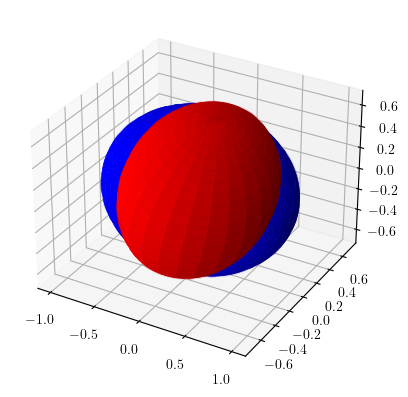

In [85]:
plotEllipsoid(radii,Q,radii2,rotation)